In [1]:
# utilities
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Importing the dataset
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('training_tweets.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.sample(5)

,target,ids,date,flag,user,text
409488,0,2059659865,Sat Jun 06 17:22:43 PDT 2009,NO_QUERY,Ilkee,@thisgoeshere @strangetymes i think i'm going ...
607991,0,2223162898,Thu Jun 18 07:55:56 PDT 2009,NO_QUERY,myfizzypop,so everyone's going to be having fun this Satu...
1337619,4,2017700758,Wed Jun 03 08:48:56 PDT 2009,NO_QUERY,helenax33,@x_stevie_x bet you did amazingg
1195096,4,1984566361,Sun May 31 15:21:37 PDT 2009,NO_QUERY,whowatcheswho,"@xtoatsmagoatsx Like I said, I don't watch it ..."
889057,4,1687497590,Sun May 03 08:51:18 PDT 2009,NO_QUERY,cedgeeezy,Having mcdonalds for breakfast haven't had a ...


In [3]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
df.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

In [5]:
print('length of data is', len(df))

length of data is 1600000


In [6]:
df. shape

(1600000, 6)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [8]:
df.dtypes

target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

In [9]:
np.sum(df.isnull().any(axis=1))

0

In [10]:
print('Count of columns in the data is:  ', len(df.columns))
print('Count of rows in the data is:  ', len(df))

Count of columns in the data is:   6
Count of rows in the data is:   1600000


In [11]:
df['target'].unique()


array([0, 4], dtype=int64)

In [12]:
df['target'].nunique()

2

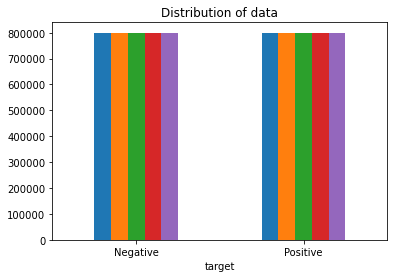

In [13]:
# Plotting the distribution for dataset.
ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
# Storing data in lists.
text, sentiment = list(df['text']), list(df['target'])

<AxesSubplot:xlabel='target', ylabel='count'>

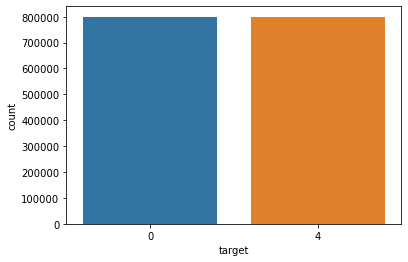

In [14]:
import seaborn as sns
sns.countplot(x='target', data=df)

In [15]:
data=df[['text','target']]

In [16]:
data['target'] = data['target'].replace(4,1)

C:\Users\dell\AppData\Local\Temp/ipykernel_10120/2499609609.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['target'].replace(4,1)


In [17]:
data['target'].unique()

array([0, 1], dtype=int64)

In [18]:
data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]

In [19]:
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]


In [20]:
dataset = pd.concat([data_pos, data_neg])

In [21]:
dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

19995    not much time off this weekend, work trip to m...
19996                            one more day of holidays 
19997    feeling so down right now .. i hate you damn h...
19998    geez,i hv to read the whole book of personalit...
19999    i threw my sign at donnie and he bent over to ...
Name: text, dtype: object

In [22]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [23]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head

<bound method NDFrame.head of 800000                love @health4uandpets u guys r best!!
800001    im meeting one besties tonight! cant wait!! - ...
800002    @darealsunisakim thanks twitter add, sunisa! g...
800003    sick really cheap hurts much eat real food plu...
800004                      @lovesbrooklyn2 effect everyone
                                ...                        
19995     not much time off weekend, work trip malmï¿½ f...
19996                                      one day holidays
19997                    feeling right .. hate damn humprey
19998     geez,i hv read whole book personality types em...
19999     threw sign donnie bent over get but thingee ma...
Name: text, Length: 40000, dtype: object>

In [24]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [25]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [26]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [27]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [28]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'w+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].head()

800000           []
800001          [w]
800002    [w, w, w]
800003           []
800004           []
Name: text, dtype: object

In [29]:
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

800000           []
800001          [w]
800002    [w, w, w]
800003           []
800004           []
Name: text, dtype: object

In [30]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

800000           []
800001          [w]
800002    [w, w, w]
800003           []
800004           []
Name: text, dtype: object

In [31]:
X=data.text
y=data.target

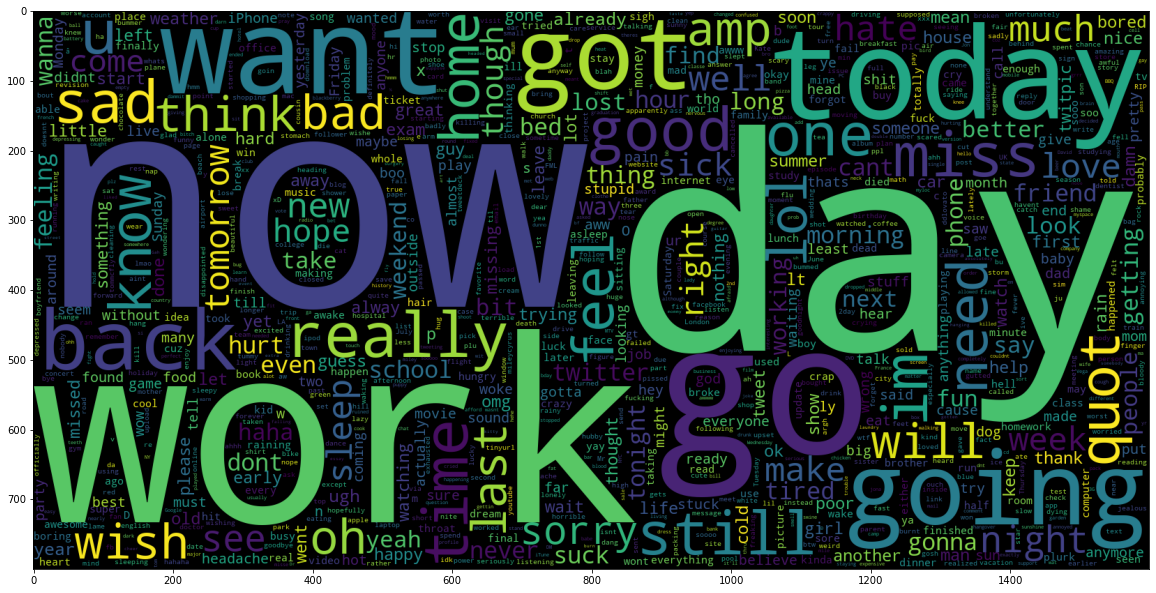

In [32]:
data_neg = data['text'][:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

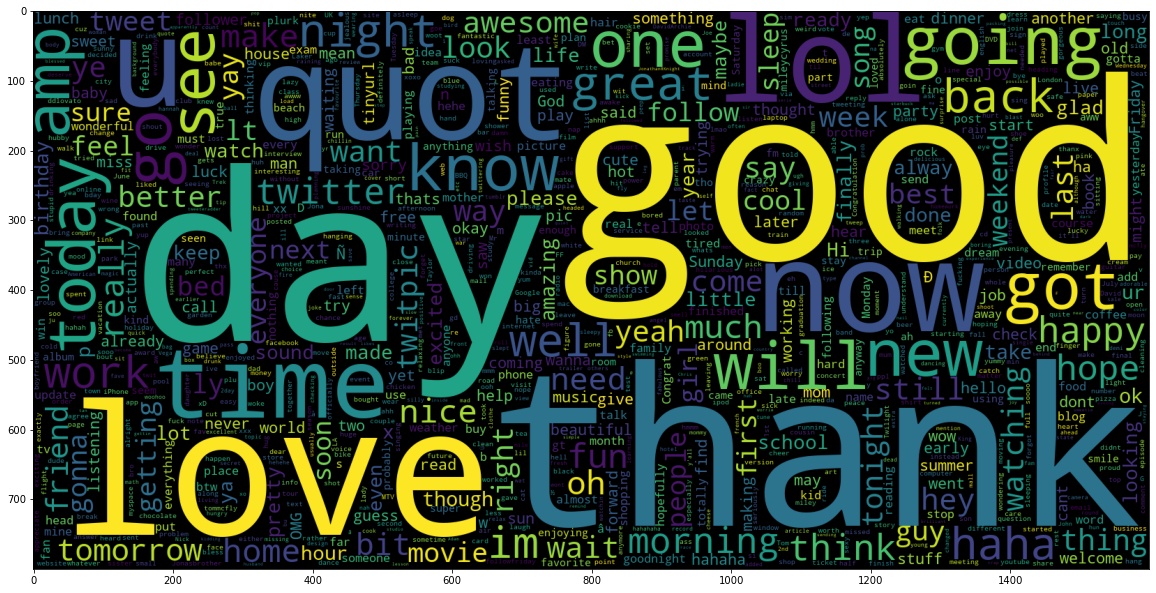

In [33]:
data_pos = data['text'][800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [34]:
# Separating the 95% data for training data and 5% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =26105111)

In [35]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

No. of feature_words:  500000


In [36]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [37]:
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### Using Navie Bayes

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     40100
           1       0.80      0.81      0.80     39900

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



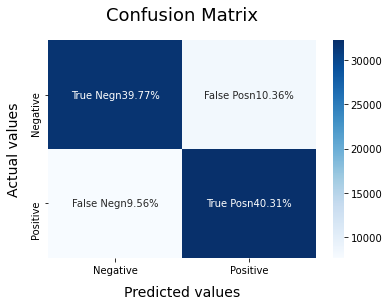

In [38]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)


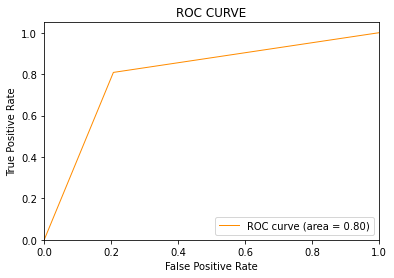

In [39]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

# Using SVM 

              precision    recall  f1-score   support

           0       0.82      0.81      0.81     40100
           1       0.81      0.82      0.82     39900

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



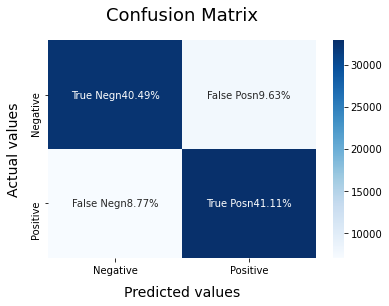

In [40]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

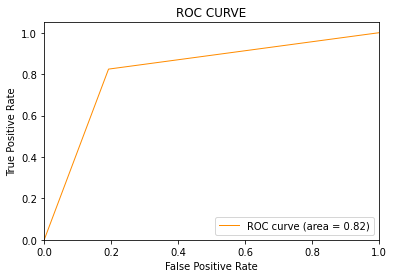

In [41]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

### Using Logistic Regression

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     40100
           1       0.82      0.84      0.83     39900

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



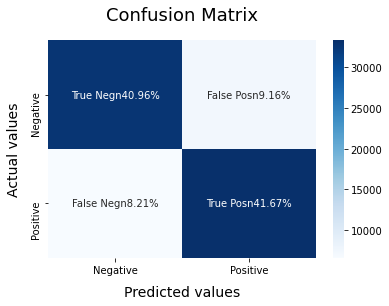

In [42]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

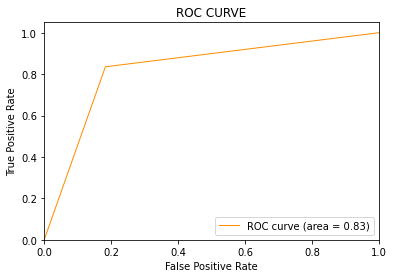

In [43]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

### Using CNN Model

In [44]:
from sklearn.model_selection import train_test_split
df_train,df_test,y_train,y_test=train_test_split(df['text'],y,test_size=0.33,random_state=42)
print('DF Train Shape: ',df_train.shape)
print('DF Test Shape: ',df_test.shape)
print('Y Train Shape: ',y_train.shape)
print('Y Test Shape: ',y_test.shape)

DF Train Shape:  (1072000,)
DF Test Shape:  (528000,)
Y Train Shape:  (1072000,)
Y Test Shape:  (528000,)


In [45]:
from tensorflow.keras.preprocessing.text import Tokenizer
max_words=10000
tokenizer=Tokenizer(max_words)
tokenizer.fit_on_texts(df_train)
sequence_train=tokenizer.texts_to_sequences(df_train)
sequence_test=tokenizer.texts_to_sequences(df_test)


In [46]:
word2vec=tokenizer.word_index
V=len(word2vec)
print('dataset has %s number of independent tokens' %V)


dataset has 527470 number of independent tokens


In [47]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
data_train=pad_sequences(sequence_train)
data_train.shape

(1072000, 116)

In [48]:
T=data_train.shape[1]
data_test=pad_sequences(sequence_test,maxlen=T)
data_test.shape

(528000, 116)

In [49]:
from tensorflow.keras.layers import Input,Conv1D,MaxPooling1D,Dense,GlobalMaxPooling1D,Embedding
from tensorflow.keras.models import Model

In [50]:
D=20
i=Input((T,))
x=Embedding(V+1,D)(i)
x=Conv1D(32,3,activation='relu')(x)
x=MaxPooling1D(3)(x)
x=Conv1D(64,3,activation='relu')(x)
x=MaxPooling1D(3)(x)
x=Conv1D(128,3,activation='relu')(x)
x=GlobalMaxPooling1D()(x)
x=Dense(5,activation='softmax')(x)
model=Model(i,x)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 116)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 116, 20)           10549420  
_________________________________________________________________
conv1d (Conv1D)              (None, 114, 32)           1952      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 38, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 36, 64)            6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 12, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 128)          

In [51]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
cnn_senti=model.fit(data_train,y_train,validation_data=(data_test,y_test),epochs=5,batch_size=100)

Epoch 1/5
10720/10720 [==============================] - 1487s 139ms/step - loss: 0.4310 - accuracy: 0.7999 - val_loss: 0.4045 - val_accuracy: 0.8162
Epoch 2/5
10720/10720 [==============================] - 1486s 139ms/step - loss: 0.3887 - accuracy: 0.8246 - val_loss: 0.3972 - val_accuracy: 0.8201
Epoch 3/5
10720/10720 [==============================] - 1486s 139ms/step - loss: 0.3719 - accuracy: 0.8337 - val_loss: 0.3983 - val_accuracy: 0.8192
Epoch 4/5
10720/10720 [==============================] - 1486s 139ms/step - loss: 0.3591 - accuracy: 0.8404 - val_loss: 0.3980 - val_accuracy: 0.8208
Epoch 5/5
10720/10720 [==============================] - 1486s 139ms/step - loss: 0.3485 - accuracy: 0.8461 - val_loss: 0.4019 - val_accuracy: 0.8192


In [52]:
y_pred=model.predict(data_test)
y_pred

array([[5.9145439e-01, 4.0854561e-01, 1.7851637e-08, 2.6714682e-08,
        2.2945267e-08],
       [6.4766741e-01, 3.5233256e-01, 1.4702199e-15, 7.3533573e-15,
        3.3551377e-15],
       [5.5501288e-01, 4.4498718e-01, 2.0799568e-20, 1.0850158e-19,
        2.6511166e-20],
       ...,
       [1.5295872e-02, 9.8470414e-01, 7.0690835e-24, 3.5795428e-23,
        9.6620338e-24],
       [8.1786084e-01, 1.8213916e-01, 8.1119183e-26, 8.7323195e-25,
        2.7204623e-25],
       [6.7317903e-01, 3.2682097e-01, 4.0226204e-23, 3.5473934e-22,
        1.1171058e-22]], dtype=float32)

In [53]:
y_pred=np.argmax(y_pred,axis=1)
y_pred

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [54]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

              precision    recall  f1-score   support

           0       0.81      0.84      0.82    263321
           1       0.83      0.80      0.82    264679

    accuracy                           0.82    528000
   macro avg       0.82      0.82      0.82    528000
weighted avg       0.82      0.82      0.82    528000

              precision    recall  f1-score   support

           0       0.81      0.84      0.82    263321
           1       0.83      0.80      0.82    264679

    accuracy                           0.82    528000
   macro avg       0.82      0.82      0.82    528000
weighted avg       0.82      0.82      0.82    528000



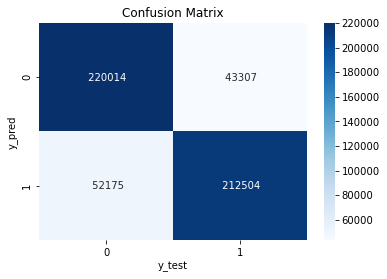

In [55]:
cm=confusion_matrix(y_test,y_pred)
ax=sns.heatmap(cm,annot=True,cmap='Blues',fmt=' ')
ax.set_title('Confusion Matrix')
ax.set_xlabel('y_test')
ax.set_ylabel('y_pred')
print(classification_report(y_test,y_pred))
print(classification_report(y_test,y_pred))